## Setup

In [ ]:
!pip install fastai -q --upgrade
!pip install -q --upgrade --force-reinstall --no-deps kaggle
!pip install split-folders tqdm

In [ ]:
from fastai.data.all import *
from fastai.vision.all import *

import pandas

from google.colab import files

import splitfolders

import os

from PIL import Image

In [ ]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c global-wheat-detection -p data

In [ ]:
data_path = untar_data("/content/data/global-wheat-detection.zip")

In [ ]:
%cd /content/data/global-wheat-detection
f_names = set()
for f_name in os.listdir(data_path):
  f_names.add(f_name.split(".")[0])
for f_name in f_names:
  with open(f"{f_name}.txt", "w") as f:
    pass

/content/data/global-wheat-detection


In [ ]:
df = pandas.read_csv(data_path.parent / "train.csv", converters={'bbox': eval})
df.loc[:, ('bbox')] = df.loc[:, ('bbox')].apply(lambda bbox : " ".join(str(coord) for coord in bbox))

In [ ]:
df.tail()

,image_id,width,height,bbox,source
147788,5e0747034,1024,1024,64.0 619.0 84.0 95.0,arvalis_2
147789,5e0747034,1024,1024,292.0 549.0 107.0 82.0,arvalis_2
147790,5e0747034,1024,1024,134.0 228.0 141.0 71.0,arvalis_2
147791,5e0747034,1024,1024,430.0 13.0 184.0 79.0,arvalis_2
147792,5e0747034,1024,1024,875.0 740.0 94.0 61.0,arvalis_2


In [ ]:
def annotations_from_df(df, path):
  image_ids = df.image_id.unique()
  for image_id in image_ids:
    with open(Path(path) / f"{image_id}.txt", "w") as f:
      for row in df.loc[df.image_id == image_id].itertuples():
        f.write(f"0 {row.bbox}\n")

In [ ]:
annotations_from_df(df, data_path)

In [ ]:
%cd /content/data/
%mkdir input/
!mv global-wheat-detection input/
data_path = data_path.parent / "input"
%cd ..

/content/data
/content


In [ ]:
data_path

Path('/content/data/input')

In [ ]:
splitfolders.ratio(data_path, output="/content/splitted_data", seed=42, ratio=(.8, .2), group_prefix=2)

Copying files: 3422 files [00:41, 83.06 files/s]


In [ ]:
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
!mv splitted_data/train/global-wheat-detection darknet/data/train
!mv splitted_data/val/global-wheat-detection darknet/data/valid

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!make

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
len(set(os.listdir("/content/darknet/data/train")))//2

2737

In [ ]:
6000*0.8

4800.0

In [ ]:
6000*0.9

5400.0

In [ ]:
%cd /content/darknet/data/

/content/darknet/data


In [ ]:
!echo wheat > obj.names

In [ ]:
def generate_fnames_txt(d):
  f_names = set()
  for f_name in os.listdir(d):
    f_names.add(f_name.split(".")[0])
  with open(f"{d}.txt", "w") as f:
    for f_name in f_names:
      f.write(f"data/{d}/{f_name}.jpg\n")

In [ ]:
generate_fnames_txt("train")
generate_fnames_txt("valid")

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!ln -s /content/gdrive/"My Drive"/ /mydrive

Mounted at /content/gdrive


In [ ]:
with open("obj.data", "w") as f:
  f.write("classes = 1\n")
  f.write("train = data/train.txt\n")
  f.write("valid = data/valid.txt\n")
  f.write("names = data/obj.names\n")
  f.write("backup = /mydrive/kaggle/global-wheat-detection/backup\n")

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
def format_yolo_annotations(d):
  f_names = set()
  for f_name in os.listdir(d):
    f_names.add(f_name.split(".")[0])
  for f_name in f_names:
    lines = []
    with open(f"{d}/{f_name}.txt", "r") as f:
      lines = f.readlines()
    img_w, img_h = Image.open(f"{d}/{f_name}.jpg").size
    new_lines = []
    for line in lines:
      _, x0, y0, w, h = (map(float, line.strip().split()))
      new_lines.append("0 {} {} {} {}\n".format((x0 + w / 2) / img_w, (y0 + h / 2) / img_h, w / img_w, h / img_h))
    with open(f"{d}/{f_name}.txt", "w") as f:
      for new_line in new_lines:
        f.write(new_line)

In [ ]:
format_yolo_annotations("data/train")
format_yolo_annotations("data/valid")

In [ ]:
!cat data/train/afd82a1d7.txt

## Remember to change yolov4-custom.cfg!

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map
# !./darknet detector train data/obj.data cfg/yolov4-custom.cfg /mydrive/kaggle/global-wheat-detection/backup/yolov4-custom_last.weights -dont_show -map

## Run predictions

In [ ]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 

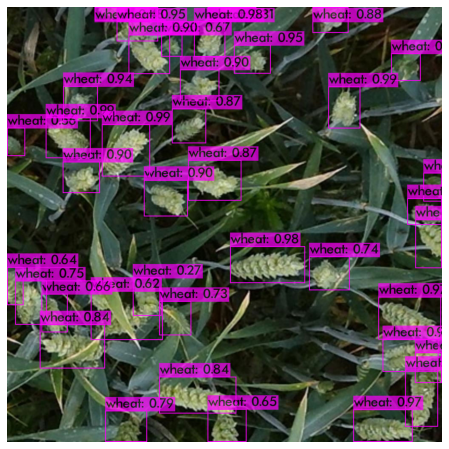

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg /mydrive/kaggle/global-wheat-detection/backup/yolov4-custom_last.weights /content/darknet/data/train/00764ad5d.jpg -dont_show
im = Image.open("predictions.jpg")
ax = show_image(im, figsize=(8,8))